In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [12]:
CSV_PATH = "Coca-Cola_stock_history.csv"
DATE_COL = "Date"
TARGET_COL = "Close"
TEST_SIZE_DAYS = 365
RF_SAVE_PATH = "rf_model.pkl"
LSTM_SAVE_PATH = "lstm_model.h5"
SCALER_MM_PATH = "scaler_mm.pkl"
SCALER_STD_PATH = "scaler_std.pkl"
SEED = 42


np.random.seed(SEED)

In [13]:
def load_data(path):
    df = pd.read_csv(path)
    # ensure date parsing
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
    df = df.sort_values(DATE_COL).reset_index(drop=True)
    return df

In [14]:
def feature_engineer(df):
    """
    Adds:
    - MA_20, MA_50 (moving averages)
    - Daily_Return
    - Volatility (rolling std of returns over 20 days)
    - Year, Month, Day as possible features
    """
    df = df.copy()
    df['MA_20'] = df[TARGET_COL].rolling(window=20, min_periods=1).mean()
    df['MA_50'] = df[TARGET_COL].rolling(window=50, min_periods=1).mean()
    df['Daily_Return'] = df[TARGET_COL].pct_change().fillna(0)
    df['Volatility'] = df['Daily_Return'].rolling(window=20, min_periods=1).std().fillna(0)
    # Optional additional features
    df['Year'] = df[DATE_COL].dt.year
    df['Month'] = df[DATE_COL].dt.month
    df['Day'] = df[DATE_COL].dt.day
    return df


In [15]:
def clean_data(df):
    df = df.copy()
    # forward-fill numeric columns, then drop any remaining NA
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].ffill()
    df = df.dropna().reset_index(drop=True)
    return df


In [16]:
def train_test_split_time(df, test_days=TEST_SIZE_DAYS):
    """
    Splits the dataframe into train/test by time. Test set is last `test_days` rows.
    """
    if test_days <= 0 or test_days >= len(df):
        raise ValueError("Invalid test_days compared to dataframe length.")
    train = df.iloc[:-test_days].copy()
    test = df.iloc[-test_days:].copy()
    return train, test


In [17]:
# --- RandomForest baseline (tabular features) ---
def rf_baseline(train, test, feature_cols, target_col=TARGET_COL):
    X_train = train[feature_cols].values
    y_train = train[target_col].values
    X_test = test[feature_cols].values
    y_test = test[target_col].values

    # scale features for RF (Standard)
    scaler_std = StandardScaler()
    X_train_s = scaler_std.fit_transform(X_train)
    X_test_s = scaler_std.transform(X_test)

    rf = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X_train_s, y_train)

    # predictions
    preds = rf.predict(X_test_s)
    mae = mean_absolute_error(y_test, preds)
    # Calculate RMSE manually if 'squared' argument is not supported
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    # persist
    joblib.dump(rf, RF_SAVE_PATH)
    joblib.dump(scaler_std, SCALER_STD_PATH)
    print(f"[RF] MAE: {mae:.4f}, RMSE: {rmse:.4f} -- saved to {RF_SAVE_PATH}, {SCALER_STD_PATH}")
    return rf, preds, mae, rmse


In [18]:
# --- LSTM model (sequences on scaled close price + features) ---
def create_sequences(data_array, seq_len):
    X, y = [], []
    for i in range(len(data_array) - seq_len):
        X.append(data_array[i:i+seq_len])
        y.append(data_array[i+seq_len, 0])  # assuming first column is the target (Close)
    return np.array(X), np.array(y)


In [19]:
def lstm_pipeline(train, test, feature_cols, seq_len=60, epochs=30, batch_size=32):
    # For LSTM we use MinMaxScaler on the feature set so values are in (0,1)
    mm_scaler = MinMaxScaler()
    train_vals = train[feature_cols].values
    test_vals = test[feature_cols].values
    all_vals = np.vstack([train_vals, test_vals])
    mm_scaler.fit(all_vals)
    train_scaled = mm_scaler.transform(train_vals)
    test_scaled = mm_scaler.transform(test_vals)

    # Save MinMax scaler
    joblib.dump(mm_scaler, SCALER_MM_PATH)

    # Create sequences (we'll include all features; target is column 0 -> Close must be first in feature_cols)
    train_arr = train_scaled
    test_arr = test_scaled

    X_train, y_train = create_sequences(train_arr, seq_len)
    X_test, y_test = create_sequences(np.vstack([train_arr[-seq_len:], test_arr]), seq_len)

    # reshape for LSTM: (samples, timesteps, features)
    n_features = X_train.shape[2]
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # callbacks
    es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    mc = ModelCheckpoint(LSTM_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es, mc],
        verbose=1
    )

    # Evaluate on X_test
    preds_scaled = model.predict(X_test).flatten()
    # preds_scaled are scaled in terms of the target's scale inside MinMaxScaler.
    # We need to inverse-transform predictions back to original scale.
    # To do that, recreate a "single-step" inverse by building arrays where the first column is predicted values
    # and the rest are taken from the corresponding last step input (works because MinMax was fit on all features).
    def inv_transform_preds(preds, X_reference):
        # X_reference: array of shape (n_samples, seq_len, n_features) -- use last time step as context
        refs = X_reference[:, -1, :].copy()  # shape (n_samples, n_features)
        invs = []
        for p, r in zip(preds, refs):
            arr = r.copy()
            arr[0] = p  # place predicted scaled target into first column
            inv = mm_scaler.inverse_transform(arr.reshape(1, -1))[0, 0]  # inverse transform and take target
            invs.append(inv)
        return np.array(invs)

    preds_inv = inv_transform_preds(preds_scaled, X_test)
    # Build y_test original-scale values
    def inv_transform_targets(y_scaled, X_reference):
        refs = X_reference[:, -1, :].copy()
        invs = []
        for y_s, r in zip(y_scaled, refs):
            arr = r.copy()
            arr[0] = y_s
            inv = mm_scaler.inverse_transform(arr.reshape(1, -1))[0, 0]
            invs.append(inv)
        return np.array(invs)

    y_test_inv = inv_transform_targets(y_test, X_test)

    mae = mean_absolute_error(y_test_inv, preds_inv)
    # Calculate RMSE manually if 'squared' argument is not supported
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))

    print(f"[LSTM] MAE: {mae:.4f}, RMSE: {rmse:.4f} -- model saved to {LSTM_SAVE_PATH}")
    # model already saved via ModelCheckpoint
    return model, preds_inv, y_test_inv, mae, rmse


In [20]:
def plot_results(dates, true_vals, preds, title="Model predictions vs True"):
    plt.figure(figsize=(12,6))
    plt.plot(dates, true_vals, label="True")
    plt.plot(dates, preds, label="Predicted")
    plt.legend()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(TARGET_COL)
    plt.tight_layout()
    plt.show()


[RF] MAE: 8.1969, RMSE: 10.0280 -- saved to rf_model.pkl, scaler_std.pkl


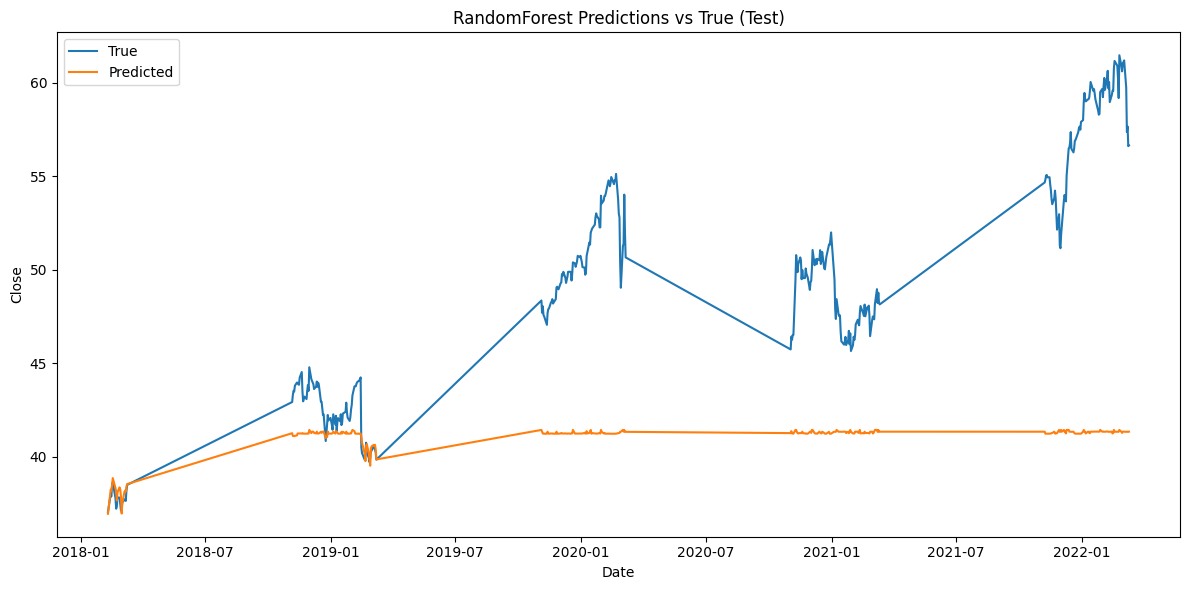

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0046 - mae: 0.0413
Epoch 1: val_loss improved from inf to 0.00072, saving model to lstm_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.0046 - mae: 0.0412 - val_loss: 7.2250e-04 - val_mae: 0.0198
Epoch 2/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.0844e-04 - mae: 0.0128
Epoch 2: val_loss did not improve from 0.00072
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 4.0830e-04 - mae: 0.0128 - val_loss: 7.8516e-04 - val_mae: 0.0236
Epoch 3/25
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 6.2400e-04 - mae: 0.0150
Epoch 3: val_loss did not improve from 0.00072
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 6.2146e-04 - mae: 0.0149 - val_loss: 0.0031 - val_mae: 0.0488
Epoch 4/25
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.9134e-04 - mae: 0.0107
Epoch 4: val_loss did not improve from 0.00072
171/171 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 2.9094e-04 - mae: 0.0106 - val_loss: 0.0064 - val_mae: 0.0746
Epoch 5/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.1024e-04 - mae: 0.0090
Epoch 5: val_loss did not improve from 0.00072
171/171 ━━━━

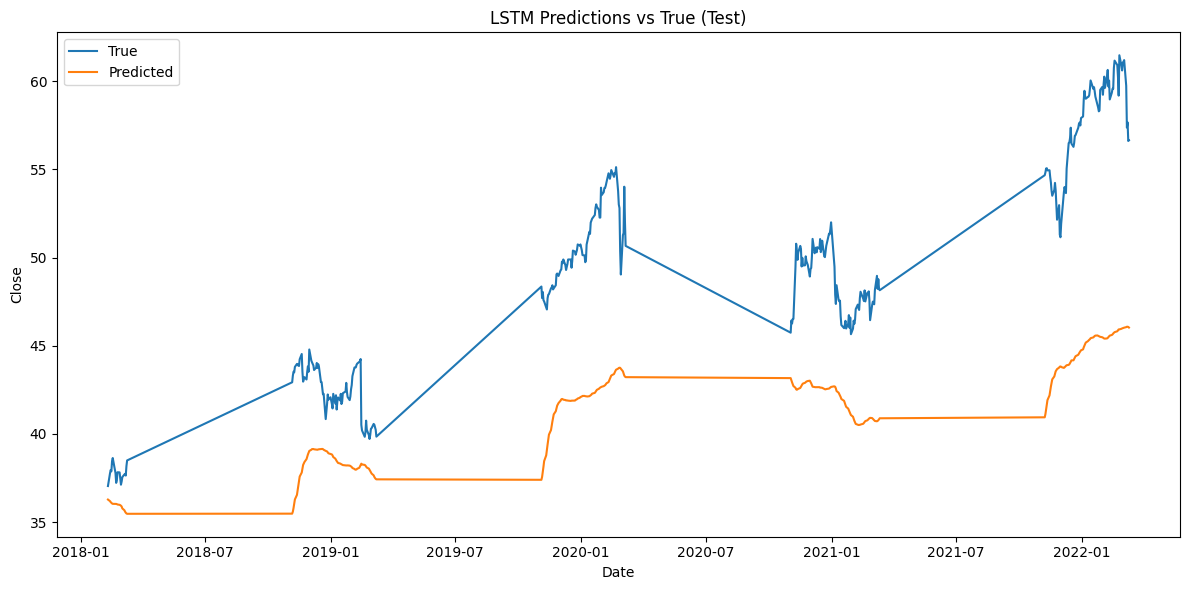

In [21]:
def main():
    #if not os.path.exists(CSV_PATH):
        #raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Please provide the Coca-Cola CSV.")
    df = load_data(CSV_PATH)
    df_fe = feature_engineer(df)
    df_clean = clean_data(df_fe)

    # choose feature list where first column is the target (Close) for LSTM inverse transform convenience
    feature_cols = [TARGET_COL, 'Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility', 'Year', 'Month', 'Day']

    # ensure all feature_cols exist
    missing = [c for c in feature_cols if c not in df_clean.columns]
    if missing:
        raise ValueError("Missing expected columns after feature engineering: " + ", ".join(missing))

    train, test = train_test_split_time(df_clean, test_days=TEST_SIZE_DAYS)

    # RandomForest baseline on tabular features
    rf_features = ['Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility']
    rf, rf_preds, rf_mae, rf_rmse = rf_baseline(train, test, rf_features)

    # Optionally plot RF predictions for the test period
    test_dates = test[DATE_COL].iloc[len(test) - len(rf_preds):]  # ensure alignment
    try:
        plot_results(test_dates, test[TARGET_COL].values, rf_preds, title="RandomForest Predictions vs True (Test)")
    except Exception:
        pass

    # LSTM pipeline
    # For LSTM we pass feature_cols with TARGET_COL first
    lstm_model, lstm_preds, lstm_y_true, lstm_mae, lstm_rmse = lstm_pipeline(train, test, feature_cols, seq_len=60, epochs=25, batch_size=32)

    # Plot LSTM results (use last len(preds) dates from test set)
    try:
        # compute aligned dates for predictions
        # After sequence creation test predictions correspond to some subset; we used test sequences from combined tail+test,
        # so map predictions to test dataframe's dates conservatively:
        aligned_dates = test[DATE_COL].iloc[0:len(lstm_preds)].values
        plot_results(aligned_dates, lstm_y_true, lstm_preds, title="LSTM Predictions vs True (Test)")
    except Exception:
        pass

if __name__ == "__main__":
    main()

In [23]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.1 MB/s eta 0:00:00


In [24]:
import streamlit as st
import pandas as pd
import numpy as np
import io
import os
from pathlib import Path

try:
    import joblib
except Exception:
    joblib = None

MODEL_PATH = Path("rf_model.pkl")
SCALER_PATH = Path("scaler.pkl")

FEATURES = ['year','month','day','Open', 'High', 'Low', 'Close', 'Volume']
TARGET_COL = "prediction"


@st.cache_resource
def load_model(path: Path):
    if not path.exists():
        return None
    if joblib:
        return joblib.load(path)
    import pickle
    with open(path, "rb") as f:
        return pickle.load(f)

@st.cache_resource
def load_scaler(path: Path):
    if not path.exists():
        return None
    if joblib:
        return joblib.load(path)
    import pickle
    with open(path, "rb") as f:
        return pickle.load(f)

def predict_df(model, scaler, df: pd.DataFrame):



    X = df.copy()
    # If scaler provided, apply to numeric columns only
    if scaler is not None:
        try:
            numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
            X[numeric_cols] = scaler.transform(X[numeric_cols])
        except Exception as e:
            st.warning(f"Scaler apply failed: {e}")
    preds = model.predict(X)
    # If model outputs probabilities and you want them, try predict_proba
    proba = None
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X)
        except Exception:
            proba = None
    res = pd.DataFrame({TARGET_COL: preds})
    if proba is not None:
        # append probabilities for classes
        for i in range(proba.shape[1]):
            res[f"prob_class_{i}"] = proba[:, i]
    return pd.concat([df.reset_index(drop=True), res], axis=1)

# APP LAYOUT
st.set_page_config(page_title="Model prediction - Streamlit", layout="centered")
st.title("🔮 Predict with your trained model (Streamlit)")
st.markdown("Upload a CSV with the same feature columns used during training, or use the Manual Input tab to enter values.")

# Load model & scaler
model = load_model(MODEL_PATH)
scaler = load_scaler(SCALER_PATH)

if model is None:
    st.warning(f"Model not found at `{MODEL_PATH}`. Please place your model file there or update MODEL_PATH in the script.")
else:
    st.success("Model loaded successfully.")

if FEATURES:
    st.info(f"Manual input mode: using FEATURES list with {len(FEATURES)} inputs.")

# Tabs: Upload CSV, Manual Input
tab1, tab2 = st.tabs(["Upload CSV", "Manual Input"])

with tab1:
    uploaded = st.file_uploader("Upload CSV file with features", type=["csv"])
    if uploaded is not None:
        try:
            df = pd.read_csv(uploaded)
            st.write("Preview of uploaded data (first 5 rows):")
            st.dataframe(df.head())

            if "Date" in df.columns:
                df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
                df["year"] = df["Date"].dt.year
                df["month"] = df["Date"].dt.month
                df["day"] = df["Date"].dt.day


            try:
                df = df[FEATURES]
            except KeyError as e:
                st.error(f"CSV missing required columns: {e}")
                st.stop()

            if st.button("Run predictions on uploaded CSV"):
                if model is None:
                    st.error("No model loaded.")
                else:
                    out_df = predict_df(model, scaler, df)
                    st.write("Predictions:")
                    st.dataframe(out_df.head())

                    # allow download
                    csv_bytes = out_df.to_csv(index=False).encode("utf-8")
                    st.download_button("Download predictions CSV", data=csv_bytes, file_name="predictions.csv")
        except Exception as e:
            st.error(f"Failed to read CSV: {e}")

with tab2:
    st.write("Enter values for features below and click Predict.")
    if FEATURES:
        input_data = {}
        for f in FEATURES:
            # Try to render number input by default; strings fallback
            input_data[f] = st.text_input(f, value="")
        if st.button("Predict for single sample"):
            try:
                # convert to numeric where possible
                sample = {k: (float(v) if v != "" else np.nan) for k, v in input_data.items()}
                sample_df = pd.DataFrame([sample])
                out_df = predict_df(model, scaler, sample_df)
                st.write(out_df)
            except Exception as e:
                st.error(f"Prediction failed: {e}")
    else:
        st.info("No FEATURES list configured. Please upload a CSV in the 'Upload CSV' tab or edit the FEATURES list in the script to enable manual inputs.")



# Optional: small diagnostics if model supports feature_importances_
if model is not None and hasattr(model, "feature_importances_"):
    try:
        fi = model.feature_importances_
        st.subheader("Model feature importances (top 10)")
        # Try to get feature names from FEATURES, else numeric cols of last uploaded df
        names = FEATURES if FEATURES else None
        if names is None:
            # try to inspect the model's expected input
            names = None
        if names and len(names) == len(fi):
            imp_df = pd.DataFrame({"feature": names, "importance": fi}).sort_values("importance", ascending=False).head(10)
            st.bar_chart(imp_df.set_index("feature"))
        else:
            st.info("Feature importances are available, but feature names were not configured or lengths mismatch. Configure FEATURES in the script to display them.")
    except Exception:
        pass

st.markdown("---")
st.caption("If you need this app adapted to your project's exact file layout (different model/scaler names or a specific input form), tell me and I will update the script.")


2025-11-15 10:38:43.392 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 10:38:43.395 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 10:38:44.988 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-15 10:38:44.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 10:38:44.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 10:38:44.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-15 10:38:44.999 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()

In [25]:
!streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.201.251.95:8501

  Stopping...
  Stopping...
Exception ignored in atexit callback: <function shutdown at 0x78af93a27100>
Traceback (most recent call last):
  File "/usr/lib/python3.12/logging/__init__.py", line 2264, in shutdown
    h.flush()
  File "/usr/lib/python3.12/logging/__init__.py", line 1141, in flush
    self.acquire()
  File "/usr/lib/python3.12/logging/__init__.py", line 973, in acquire
    self.lock.acquire()
  File "/usr/local/lib/python3.12/dist-packages/streamlit/web/bootstrap.py", line 42, in signal_handler
    server.stop()
  File "/usr/local/lib/python3.12/dist-packages/streamlit/web/server/server.py", line 519, in stop
    self._runtime.stop()
  File "/usr/local/lib/python3.12/dist-packages/streamlit/runtime/runtime.py", line 343, in stop
    async_objs.eventloop.call_soon_threadsafe(stop_on_eventloop)
  File